In [30]:
import numpy as np
import torch
import gc
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as torchvision_models
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from torchmetrics.image import StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchsummary import summary
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from PIL import Image
import random
import cv2
import os

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [32]:
# Define transformations for grayscale and color images
transform_gray = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.ToTensor()  # Convert images to tensors
])
transform_color = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to tensors
])
def list_files_in_directory(directory):
    files = os.listdir(directory)
    return files
train_files = list_files_in_directory("train")
test_files = list_files_in_directory("test")
validation_files = list_files_in_directory("validation")

In [33]:
def process_dataset(original_data):
    gray_data = []
    color_data = []

    for image in original_data:
        # Apply transformations
        image_resized_color = transform_color(image)
        image_resized_gray = transform_gray(image)
        
        # Convert color image tensor to HSV
        image_np = TF.to_pil_image(image_resized_color)  # Convert tensor to PIL image
        image_np = np.array(image_np)  # Convert PIL image to numpy array
        hsv_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)
        
        # Split HSV channels and normalize
        h, s, v = cv2.split(hsv_image)
        h_tensor = torch.tensor(h / 179.0, dtype=torch.float32)
        s_tensor = torch.tensor(s / 255.0, dtype=torch.float32)
        v_tensor = torch.tensor(v / 255.0, dtype=torch.float32)
        
        # Stack the channels
        hsv_tensor = torch.stack((h_tensor, s_tensor, v_tensor), dim=0)
                
        # Append the grayscale and HSV images to their respective lists
        gray_data.append(image_resized_gray)
        color_data.append(hsv_tensor)

    return gray_data, color_data


In [34]:
def read_images_from_directory(directory):
    images = []
    files = os.listdir(directory)
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
            file_path = os.path.join(directory, file)
            image = Image.open(file_path)
            images.append(image)
    return images

# Example usage
train_data = read_images_from_directory("train")
test_data = read_images_from_directory("test")
validation_data = read_images_from_directory("validation")

In [35]:
gray_data_train,      color_data_train      = process_dataset(train_data)
gray_data_test,       color_data_test       = process_dataset(test_data)
gray_data_validation, color_data_validation = process_dataset(validation_data)

In [36]:
print("Size of grayscale dataset:", len(gray_data_train))
print("Size of color dataset:", len(color_data_train))
gray_image_shape  = gray_data_train[0][0].shape
print("Shape of the first grayscale image tensor:", gray_image_shape)
color_image_shape = color_data_train[0][0].shape
print("Shape of the first color image tensor:", color_image_shape)
gray_image_shape  = gray_data_train[0].shape
print("Shape of the first grayscale image tensor:", gray_image_shape)
color_image_shape = color_data_train[0].shape
print("Shape of the first color image tensor:", color_image_shape)

Size of grayscale dataset: 69
Size of color dataset: 69
Shape of the first grayscale image tensor: torch.Size([128, 128])
Shape of the first color image tensor: torch.Size([128, 128])
Shape of the first grayscale image tensor: torch.Size([1, 128, 128])
Shape of the first color image tensor: torch.Size([3, 128, 128])


In [37]:
def plot_hsv_histograms(color_data, num_samples=3):
    for i in range(num_samples):
        index = random.randint(0, len(color_data) - num_samples)
        hsv_image = color_data[i+index]
        h, s, v = hsv_image

        # Plot histograms
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].hist(h.flatten(), bins=256, color='r')
        axes[0].set_title('Hue Histogram')
        axes[1].hist(s.flatten(), bins=256, color='g')
        axes[1].set_title('Saturation Histogram')
        axes[2].hist(v.flatten(), bins=256, color='b')
        axes[2].set_title('Value Histogram')
        plt.show()

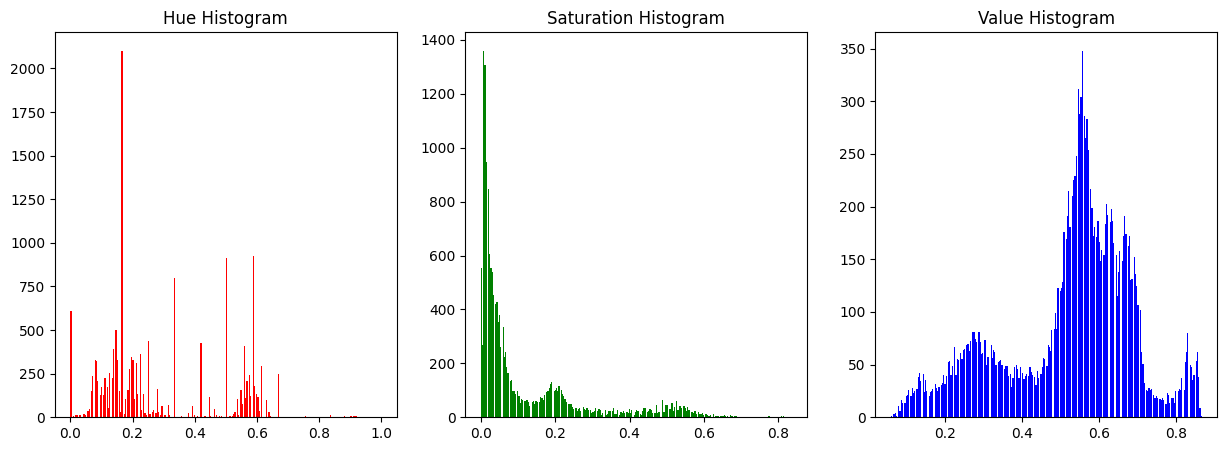

In [38]:
plot_hsv_histograms(color_data_train, num_samples=1)

In [39]:
def visualize_random_images(gray_data, color_data):
    index = random.randint(0, len(gray_data) - 1)
    gray_image = gray_data[index]
    color_image = color_data[index]

    plt.subplot(1, 2, 1)
    plt.imshow(gray_image.squeeze(0), cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(hsv_to_rgb(color_image.permute(1, 2, 0)))
    plt.title('Color Image')
    plt.axis('off')
    plt.show()


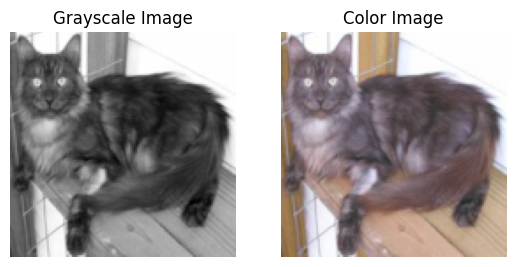

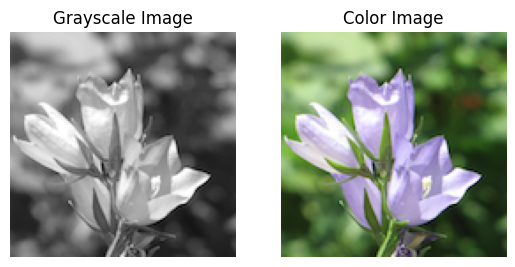

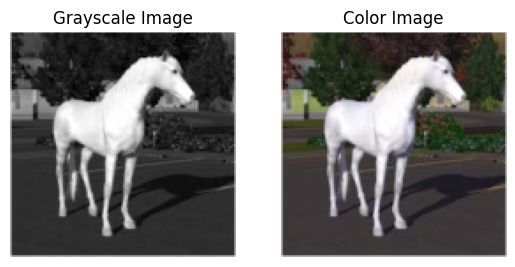

In [40]:
visualize_random_images(gray_data_train,      color_data_train)
visualize_random_images(gray_data_test,       color_data_test)
visualize_random_images(gray_data_validation, color_data_validation)

In [41]:
gray_images_train  = torch.stack(gray_data_train)
color_images_train = torch.stack(color_data_train)
gray_images_test   = torch.stack(gray_data_test)
color_images_test  = torch.stack(color_data_test)
gray_images_val    = torch.stack(gray_data_validation)
color_images_val   = torch.stack(color_data_validation)

In [42]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        
        # Decoder
        x = self.decoder(x)
        
        return x

In [43]:
Auto_encoder = ColorizationModel()
encoder = Auto_encoder.encoder
model_encoder_trained = 'model_encoder_trained.pth'
encoder.load_state_dict(torch.load(model_encoder_trained))

<All keys matched successfully>

In [44]:
gray_data_train_from_encoder = encoder(gray_images_train)
gray_data_val_from_encoder   = encoder(gray_images_val  )

dataset_train            = TensorDataset(gray_data_train_from_encoder, color_images_train)
dataset_val_from_decoder = TensorDataset(gray_data_val_from_encoder  , color_images_val  )

batch_size = 35
train_loader            = DataLoader(dataset_train           , batch_size = batch_size       , shuffle=True, pin_memory=True)
val_loader_from_decoder = DataLoader(dataset_val_from_decoder, batch_size = len(dataset_val_from_decoder), shuffle=False, pin_memory=True)

In [45]:
for batch_idx, (inputs_gray, targets_color) in enumerate(val_loader_from_decoder):
    print("Batch Index:", batch_idx)
    print("Shape of inputs (grayscale images):", inputs_gray.shape)
    print("Shape of targets (color images):"   , targets_color.shape)
    break  # Print only the first batch

Batch Index: 0
Shape of inputs (grayscale images): torch.Size([70, 128, 16, 16])
Shape of targets (color images): torch.Size([70, 3, 128, 128])


In [46]:
for batch_idx, (inputs_gray, targets_color) in enumerate(val_loader_from_decoder):
    print("Batch Index:", batch_idx)
    print("Shape of inputs (grayscale images):", inputs_gray.shape)
    print("Shape of targets (color images):"   , targets_color.shape)
num_batches = len(val_loader_from_decoder)
batch_size = val_loader_from_decoder.batch_size
print("Number of batches in val_loader:   " , num_batches)
print("Size of each batch in val_loader:  ", batch_size)

Batch Index: 0
Shape of inputs (grayscale images): torch.Size([70, 128, 16, 16])
Shape of targets (color images): torch.Size([70, 3, 128, 128])
Number of batches in val_loader:    1
Size of each batch in val_loader:   70


In [47]:
class Model_c(nn.Module):
    def __init__(self):
        super(Model_c, self).__init__()
        # Initial layer to match input channels
        self.initial_layer = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Shared layer
        self.shared_layer = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upscaling
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Output layers, resizing to [128, 128]
        self.decoder1 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
        self.decoder2 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
        self.decoder3 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial_layer(x)
        x = self.shared_layer(x)
        # Ensure each output is resized to 128x128
        output1 = F.interpolate(self.decoder1(x), size=(128, 128), mode='bilinear', align_corners=False)
        output2 = F.interpolate(self.decoder2(x), size=(128, 128), mode='bilinear', align_corners=False)
        output3 = F.interpolate(self.decoder3(x), size=(128, 128), mode='bilinear', align_corners=False)
        
        # Combine the outputs along the channel dimension to form [batch_size, 3, 128, 128]
        combined_output = torch.cat((output1, output2, output3), dim=1)
        
        return combined_output

In [48]:
def create_colorization_model_c():
    return Model_c()

In [49]:
def visualize_model_output(model, val_loader_from_decoder):
    # Select a random image from the validation loader
    inputs_gray, targets_color = next(iter(val_loader_from_decoder))
    idx = random.randint(0, len(inputs_gray) - 1)
    input_gray_sample = inputs_gray[idx]
    target_color_sample = targets_color[idx]
    
    # Generate model output
    model.eval()
    with torch.no_grad():
        output = model(input_gray_sample.unsqueeze(0).to(next(model.parameters()).device)).cpu()
    output_clipped = torch.clamp(output, 0, 1)
    
    # Create a new figure
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 5))  # Changed to 1 row and 4 columns
    
    # Plot the target color image (HSV to RGB conversion)
    target_rgb = hsv_to_rgb(target_color_sample.detach().numpy().transpose(1, 2, 0))
    axes[0].imshow(target_rgb)
    axes[0].set_title("Target Color Image")
    axes[0].axis('off')

    # Plot the model output image (HSV to RGB conversion)
    output_rgb = hsv_to_rgb(output_clipped.squeeze(0).detach().numpy().transpose(1, 2, 0))
    axes[1].imshow(output_rgb)
    axes[1].set_title("Model Output Image")
    axes[1].axis('off')
    
    # Plot histogram for the target color image
    for i in range(3):
        axes[2].hist(target_color_sample[i].detach().numpy().flatten(), bins=256, range=(0, 1), alpha=0.5, label=f'Channel {i + 1}')
    axes[2].set_title('Histogram of Target Color Image (HSV)')
    axes[2].legend()

    # Plot histograms for the model output image
    for i in range(3):
        axes[3].hist(output_clipped[0, i].detach().numpy().flatten(), bins=256, range=(0, 1), alpha=0.5, label=f'Channel {i + 1}')
    axes[3].set_title('Histogram of Model Output Image (HSV)')
    axes[3].legend()
    
    plt.tight_layout()
    plt.show()

In [50]:
Model_C = create_colorization_model_c()
Model_C.cuda()
x, y = next(iter(val_loader_from_decoder))
yHat = Model_C((x.cuda()))
print(yHat.shape)  
print(y.shape)  # Assuming y is from val_loader
summary(Model_C, (128, 16, 16))

torch.Size([70, 3, 128, 128])
torch.Size([70, 3, 128, 128])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 16, 16]         147,584
       BatchNorm2d-2          [-1, 128, 16, 16]             256
         LeakyReLU-3          [-1, 128, 16, 16]               0
   ConvTranspose2d-4           [-1, 64, 32, 32]          73,792
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         LeakyReLU-6           [-1, 64, 32, 32]               0
   ConvTranspose2d-7           [-1, 32, 64, 64]          18,464
       BatchNorm2d-8           [-1, 32, 64, 64]              64
         LeakyReLU-9           [-1, 32, 64, 64]               0
  ConvTranspose2d-10         [-1, 16, 128, 128]           4,624
      BatchNorm2d-11         [-1, 16, 128, 128]              32
        LeakyReLU-12         [-1, 16, 128, 128]               0
           Conv2d-13          [-1, 8, 128, 

In [51]:
class PerceptualLoss(nn.Module):
    def __init__(self, feature_layers=[0, 5, 10, 19, 28], use_normalization=True):
        super(PerceptualLoss, self).__init__()
        self.vgg = torchvision_models.vgg19(weights=torchvision_models.VGG19_Weights.IMAGENET1K_V1).features[:max(feature_layers)+1].eval()
        self.feature_layers = feature_layers
        self.use_normalization = use_normalization
        if use_normalization:
            self.mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to('cuda')
            self.std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to('cuda')
    
    def forward(self, x, y):
        if self.use_normalization:
            x = (x - self.mean) / self.std
            y = (y - self.mean) / self.std
        x_features = self.get_features(x)
        y_features = self.get_features(y)
        loss = sum([nn.MSELoss()(x_f, y_f) for x_f, y_f in zip(x_features, y_features)])
        return loss
    
    def get_features(self, x):
        features = []
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in self.feature_layers:
                features.append(x)
        return features

In [52]:
def train(net, criterion_list, optimizer_configs, train_loader, val_loader, epochs=10, device='cuda'):
    net.to(device)  # Move model to the correct device initially

    # Lists to store average loss per epoch for training and validation
    epoch_train_losses, epoch_val_losses = [], []

    # Generate a list of (criterion, optimizer) pairs
    pairs = []
    for crit in criterion_list:
        for optim in optimizer_configs[crit]:
            pairs.append((crit, optim))
    random.shuffle(pairs) # Shuffle the list to ensure random order of training with different pairs

    # Initialize the first pair
    current_criterion, current_optimizer = pairs[0]

    # Begin training for the specified number of epochs
    for epoch in range(1, epochs + 1):
        # Switch criterion and optimizer every 5 epochs
        if epoch % 15 == 1 and epoch > 1:
            # Move to the next pair in the list
            current_criterion, current_optimizer = pairs[(pairs.index((current_criterion, current_optimizer)) + 1) % len(pairs)]
            print(f"Epoch {epoch}: Switching to {type(current_criterion).__name__} with optimizer {type(current_optimizer).__name__}.")

        net.train()
        train_losses = []
        for inputs_gray, targets_color in train_loader:
            inputs_gray, targets_color = inputs_gray.to(device), targets_color.to(device)
            current_optimizer.zero_grad()
            outputs = net(inputs_gray)
            loss = current_criterion(outputs, targets_color)
            loss.backward(retain_graph=True)
            current_optimizer.step()
            train_losses.append(loss.item())

        average_train_loss = sum(train_losses) / len(train_losses)
        epoch_train_losses.append(average_train_loss)

        net.eval()
        val_losses = []
        with torch.no_grad():
            for inputs_gray_val, targets_color_val in val_loader:
                inputs_gray_val, targets_color_val = inputs_gray_val.to(device), targets_color_val.to(device)
                outputs_val = net(inputs_gray_val)
                loss_val = current_criterion(outputs_val, targets_color_val)
                val_losses.append(loss_val.item())

        average_val_loss = sum(val_losses) / len(val_losses)
        epoch_val_losses.append(average_val_loss)

        # Enhanced print statement with current loss function and optimizer
        if epoch % 6 == 1:
            print(f"Epoch {epoch}/{epochs}, Loss: {type(current_criterion).__name__}, Optimizer: {type(current_optimizer).__name__}, Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}")
            net.to('cpu')  # Move the model to CPU if it's not already there
            visualize_model_output(net, train_loader) 
            net.to(device)
            
    return epoch_train_losses, epoch_val_losses, net

Epoch 1/90, Loss: MSELoss, Optimizer: Adam, Train Loss: 0.3855, Val Loss: 0.1850


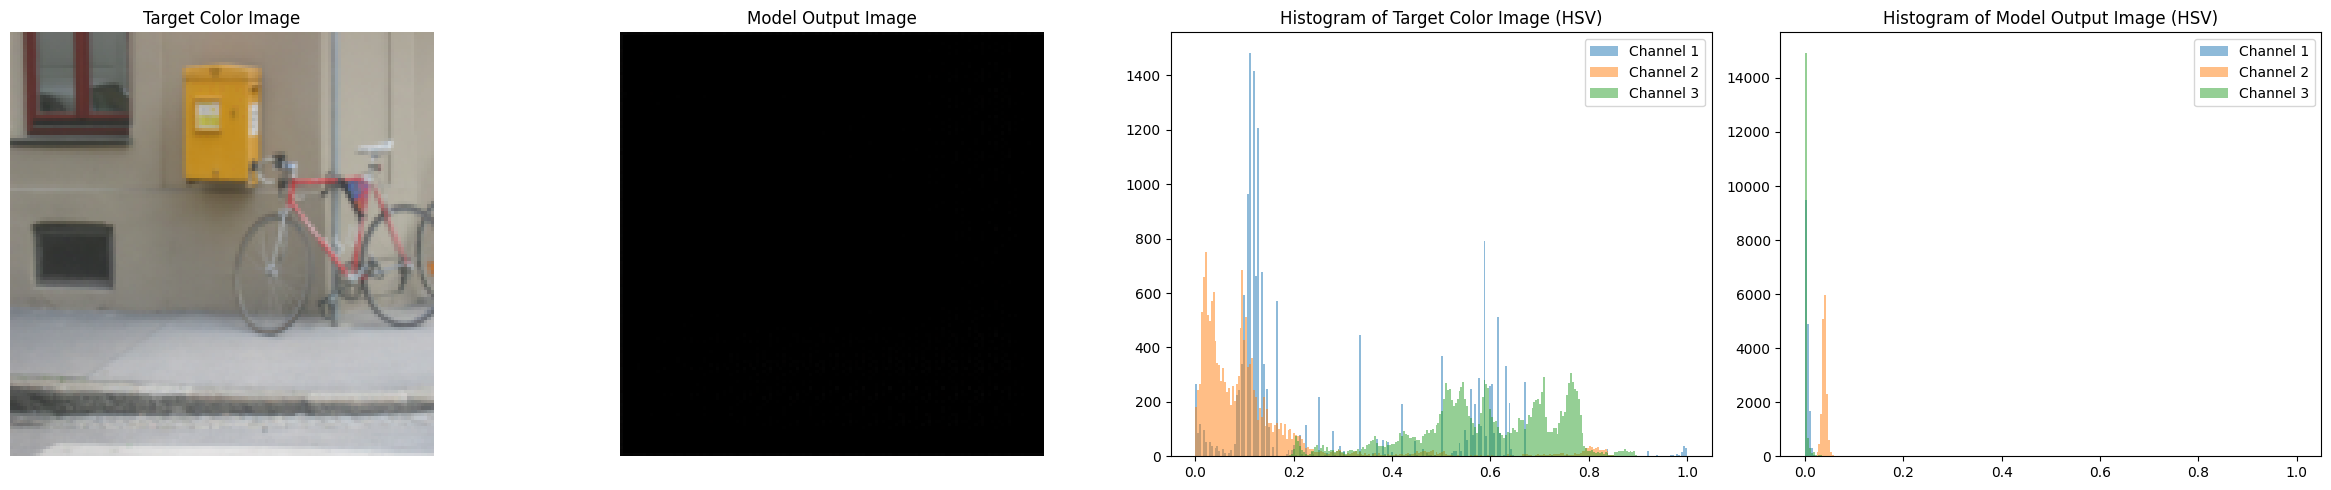

Epoch 7/90, Loss: MSELoss, Optimizer: Adam, Train Loss: 0.1856, Val Loss: 0.1683


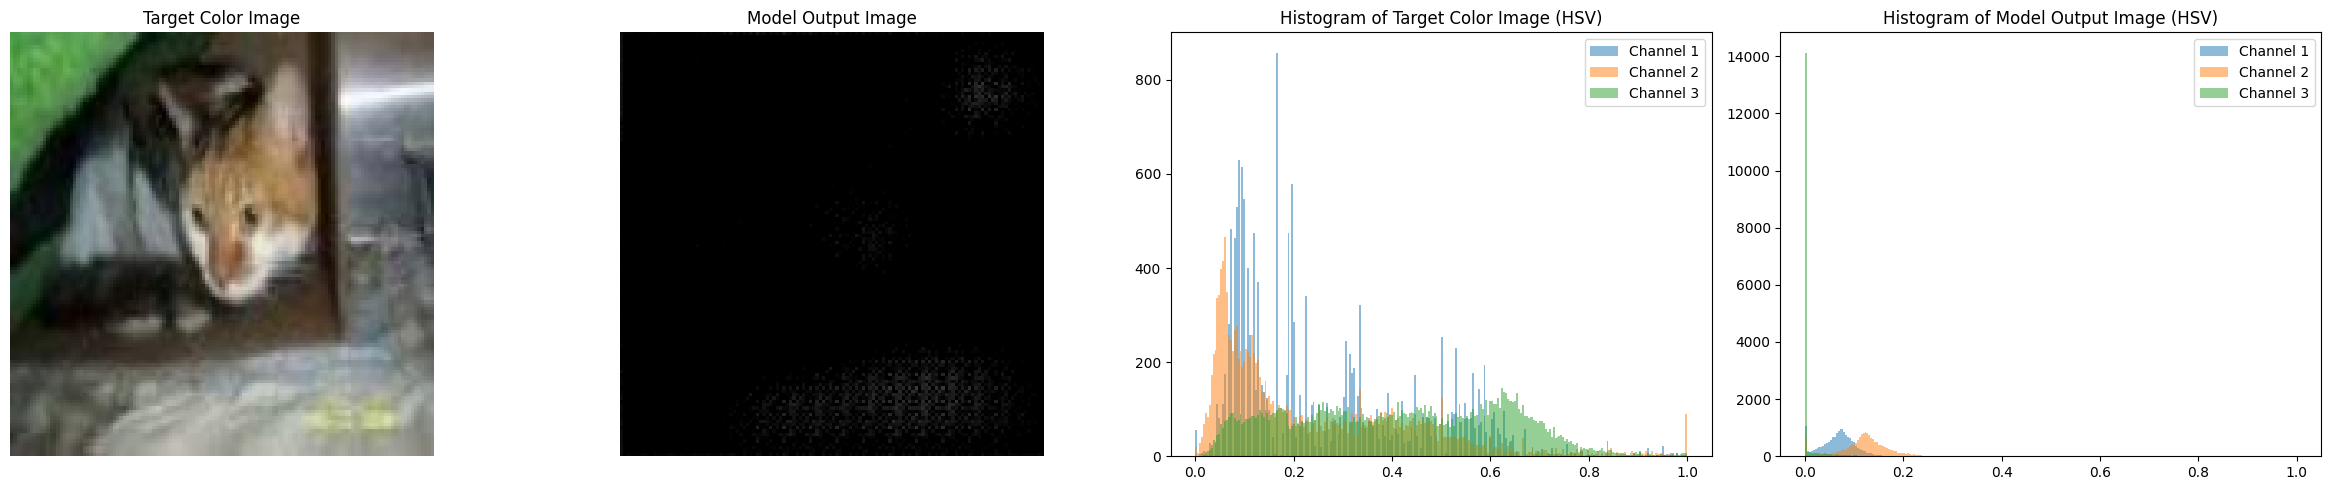

Epoch 13/90, Loss: MSELoss, Optimizer: Adam, Train Loss: 0.1270, Val Loss: 0.1249


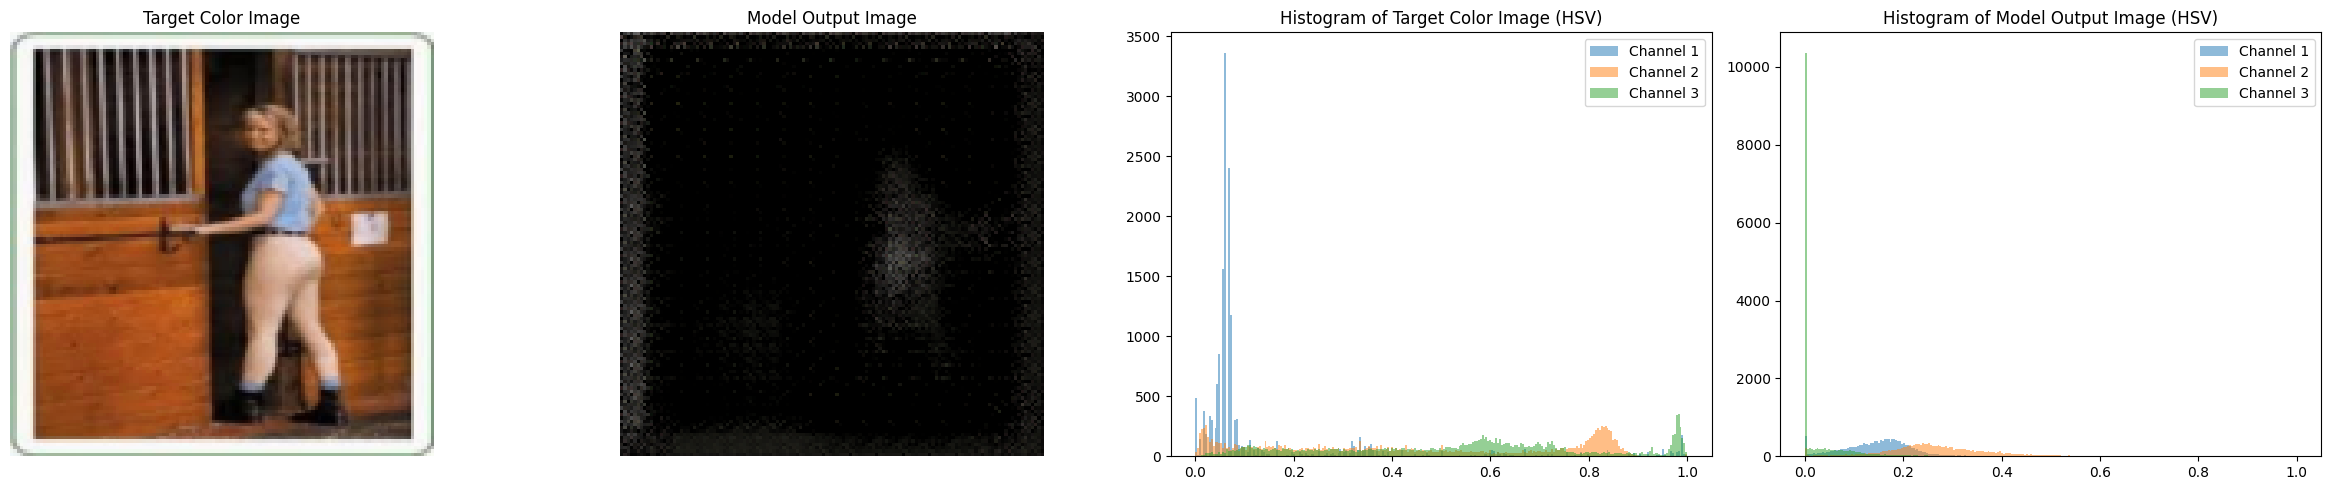

Epoch 16: Switching to function with optimizer RMSprop.
Epoch 19/90, Loss: function, Optimizer: RMSprop, Train Loss: 0.7453, Val Loss: 0.7700


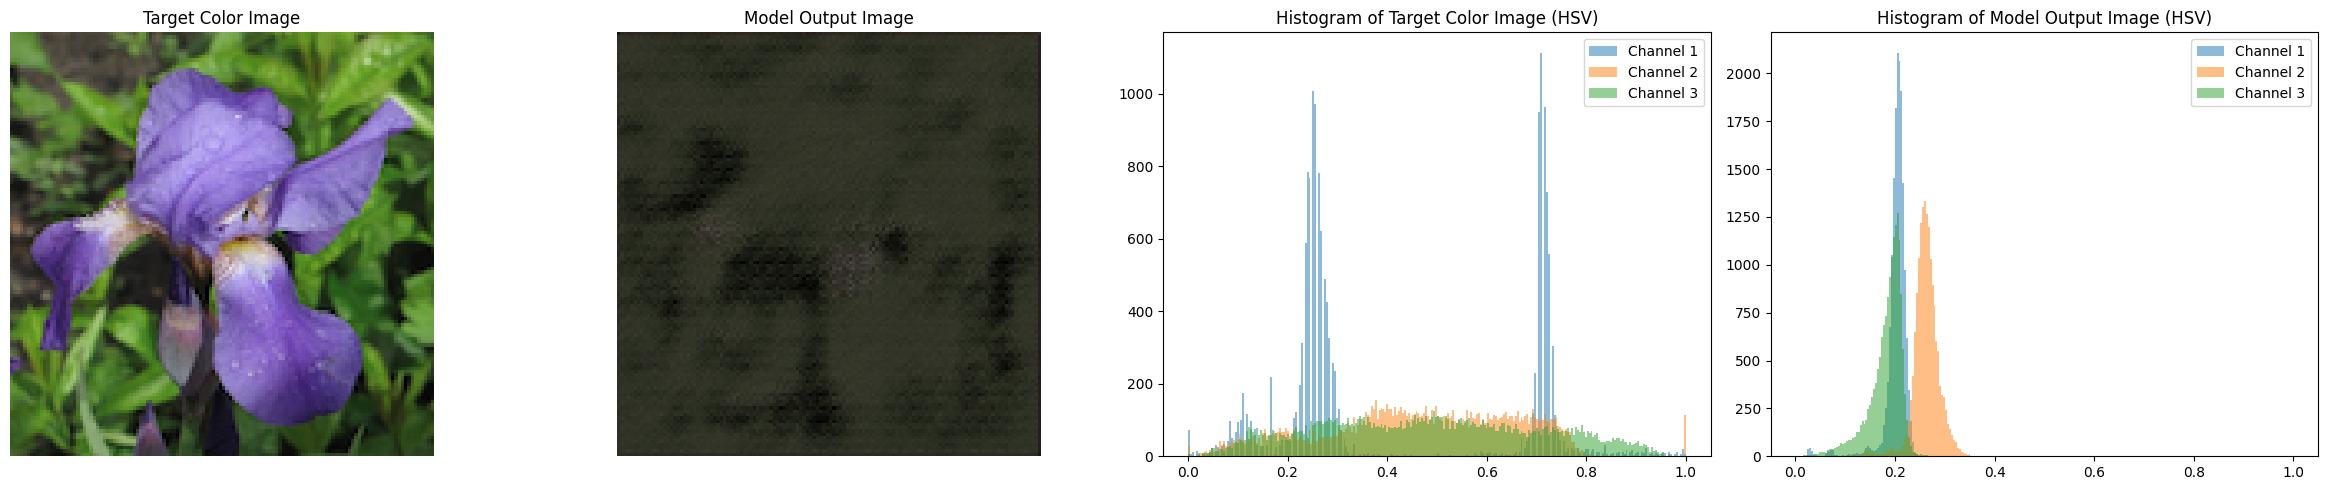

Epoch 25/90, Loss: function, Optimizer: RMSprop, Train Loss: 0.6598, Val Loss: 0.6849


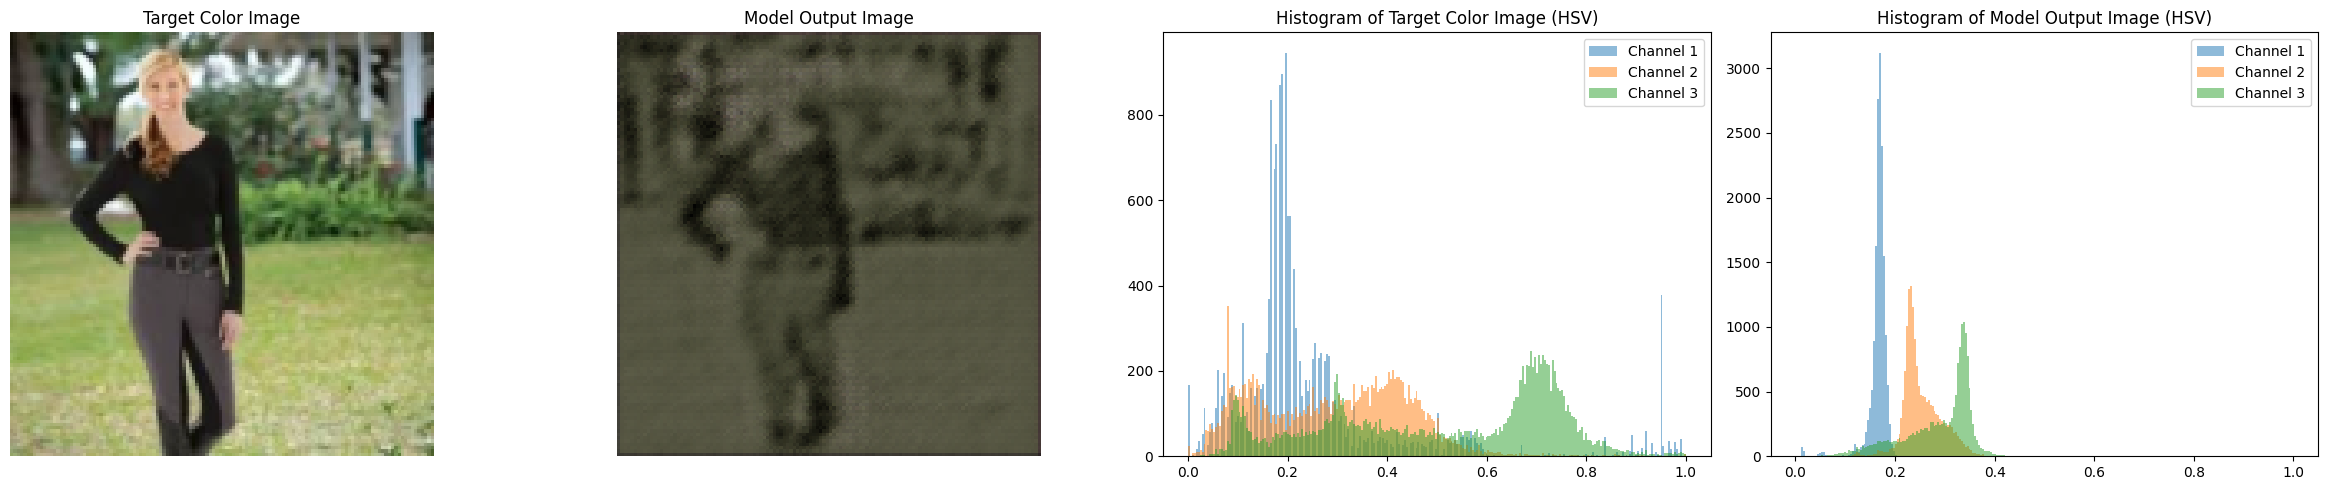

Epoch 31: Switching to function with optimizer Adam.
Epoch 31/90, Loss: function, Optimizer: Adam, Train Loss: 8.4836, Val Loss: 9.4214


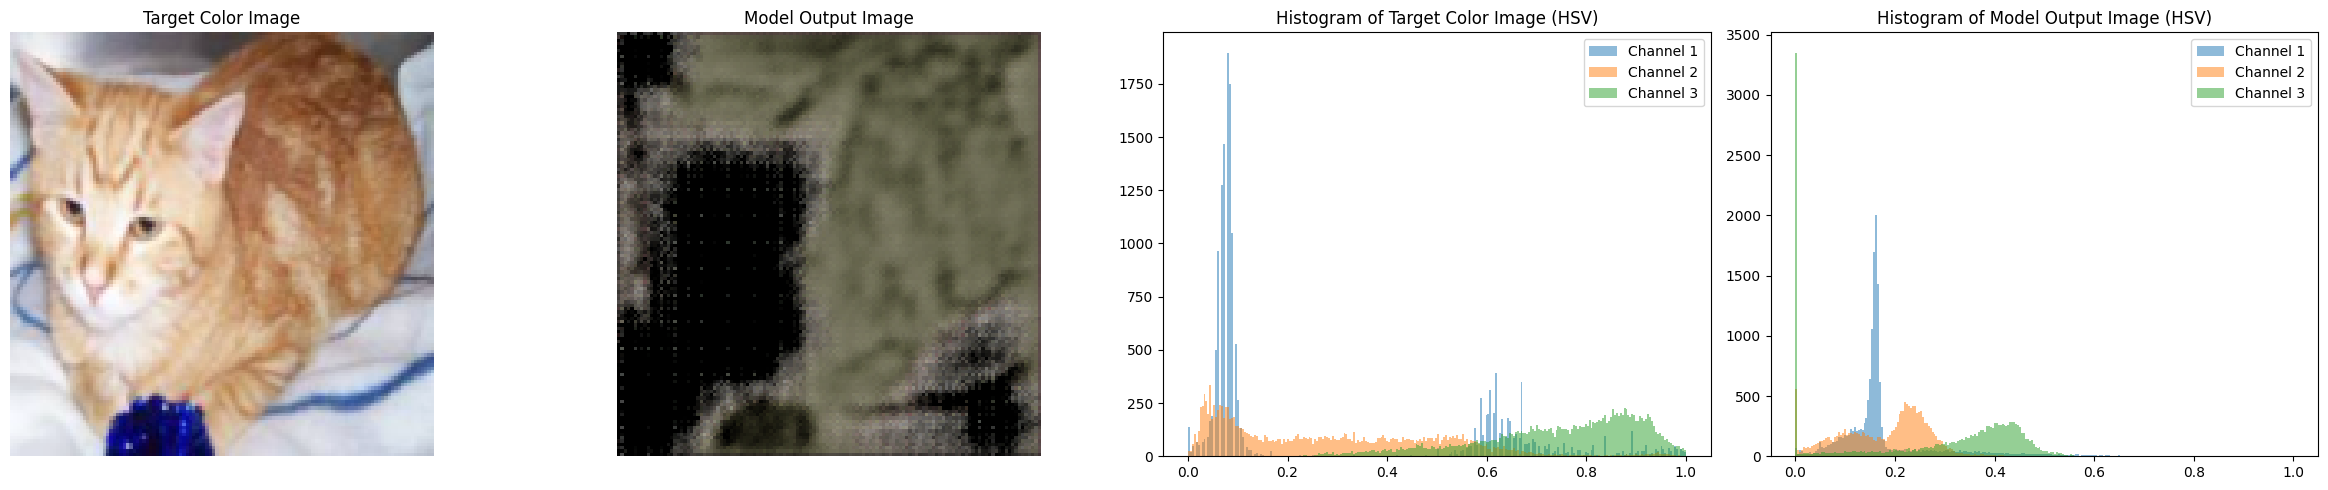

Epoch 37/90, Loss: function, Optimizer: Adam, Train Loss: 8.3242, Val Loss: 9.1430


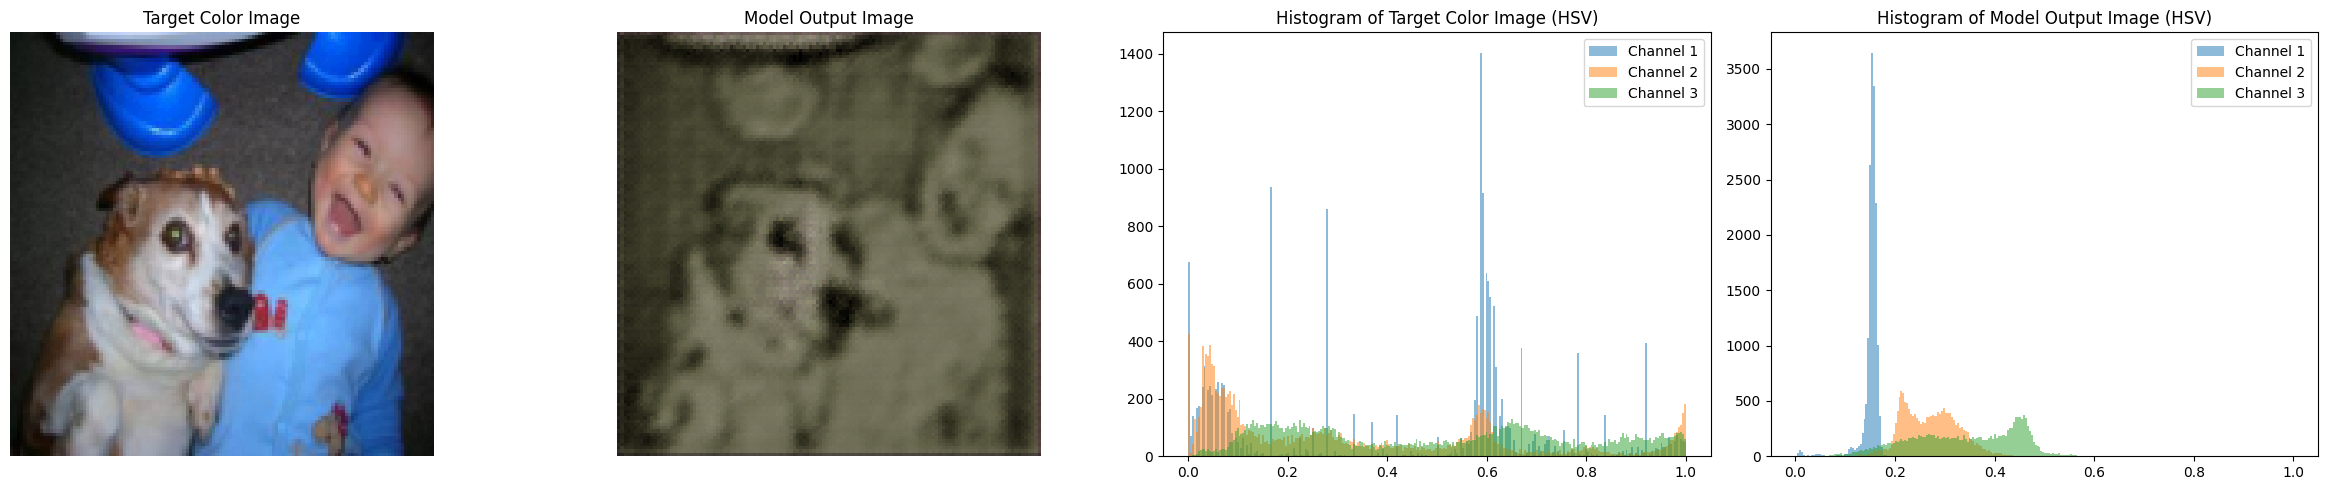

Epoch 43/90, Loss: function, Optimizer: Adam, Train Loss: 8.2086, Val Loss: 8.9408


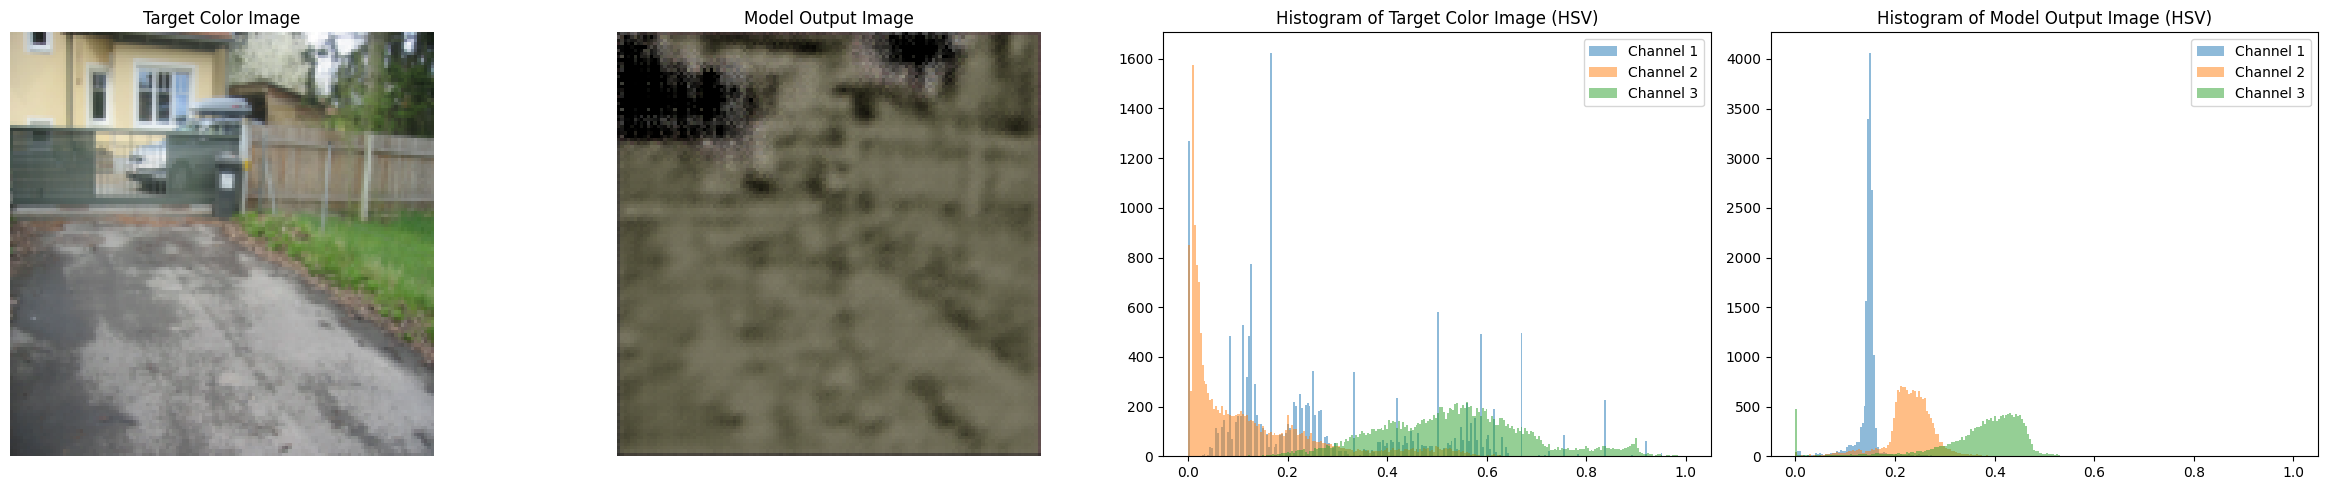

Epoch 46: Switching to function with optimizer RMSprop.
Epoch 49/90, Loss: function, Optimizer: RMSprop, Train Loss: 6.2980, Val Loss: 6.1388


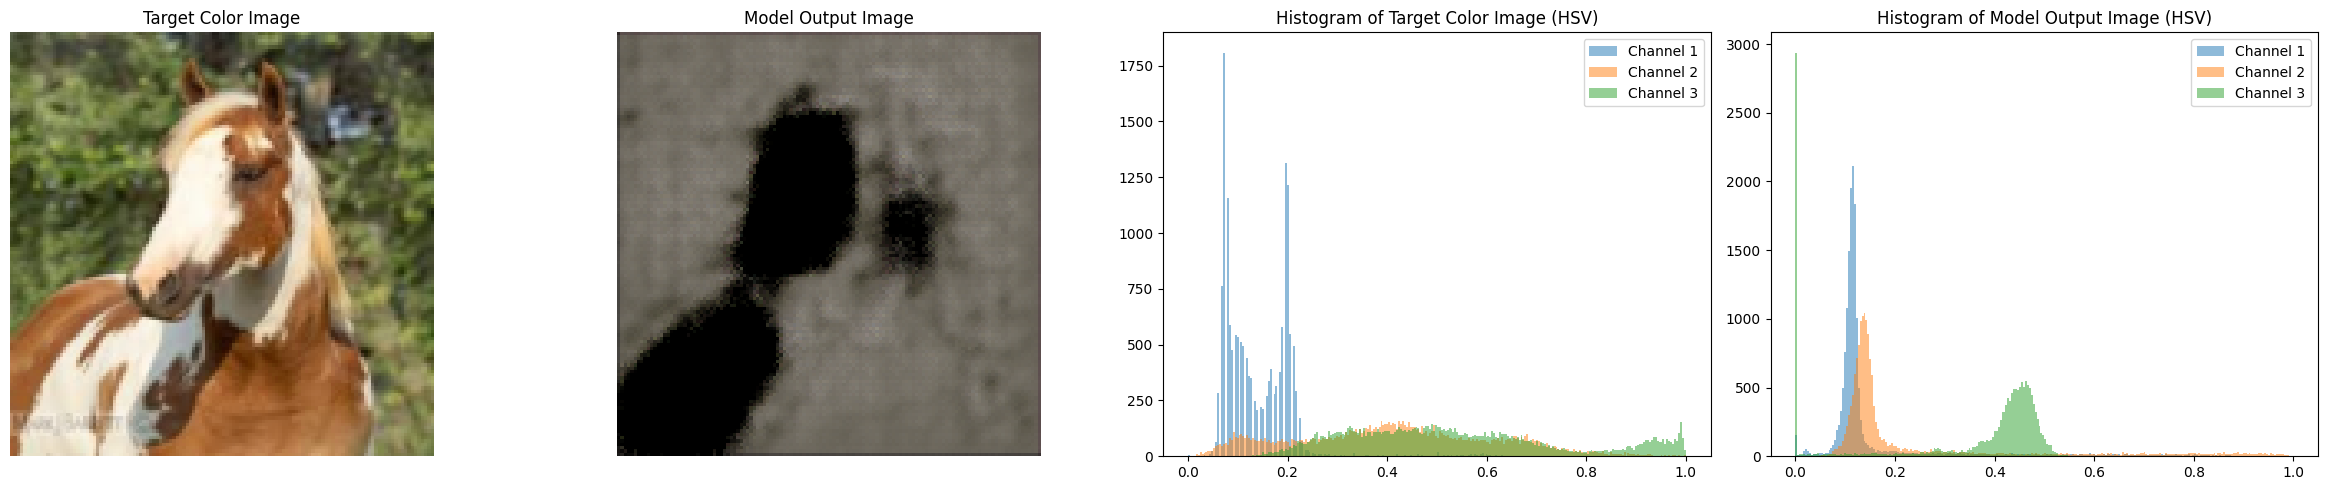

Epoch 55/90, Loss: function, Optimizer: RMSprop, Train Loss: 4.6544, Val Loss: 5.5318


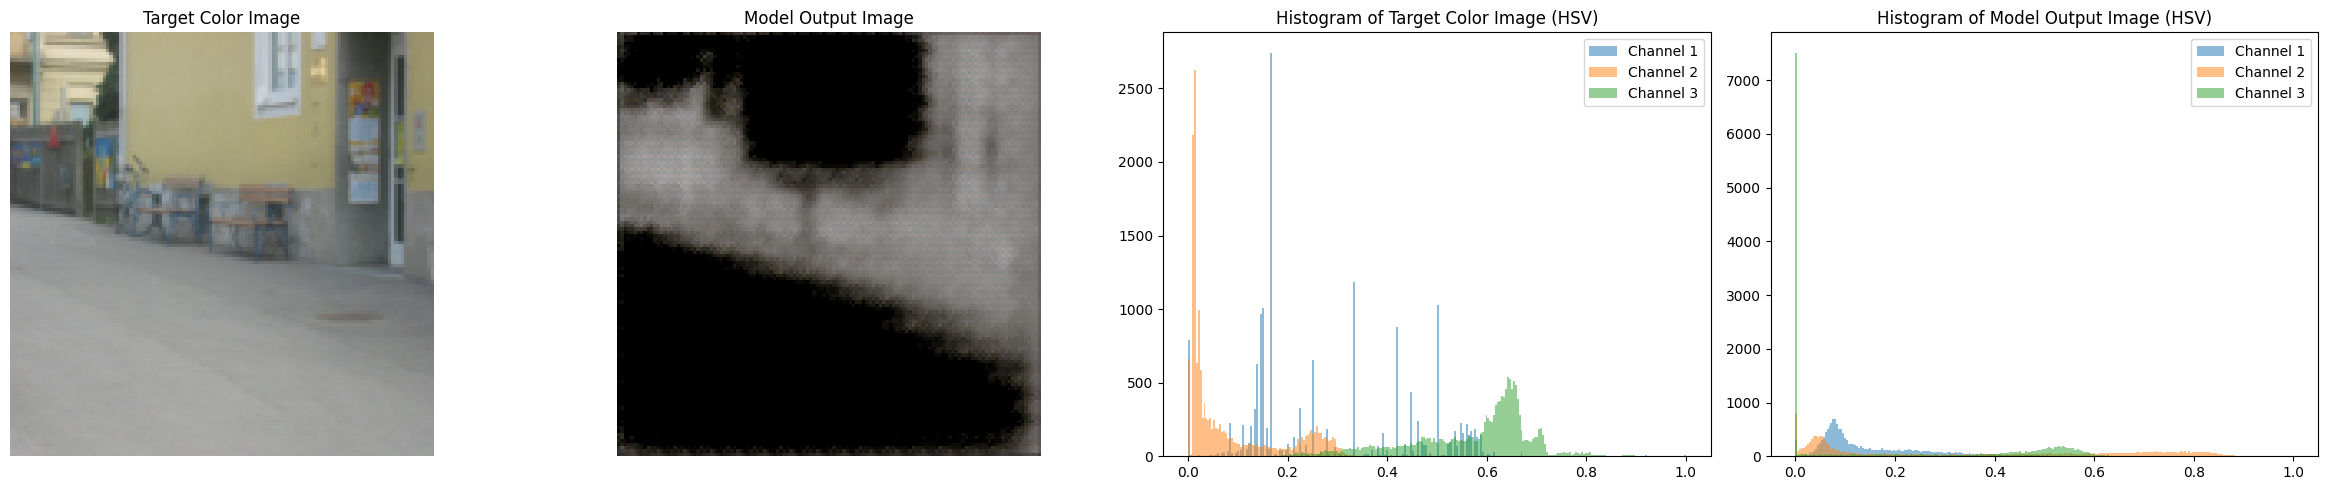

Epoch 61: Switching to PerceptualLoss with optimizer Adam.
Epoch 61/90, Loss: PerceptualLoss, Optimizer: Adam, Train Loss: 183.0131, Val Loss: 149.6672


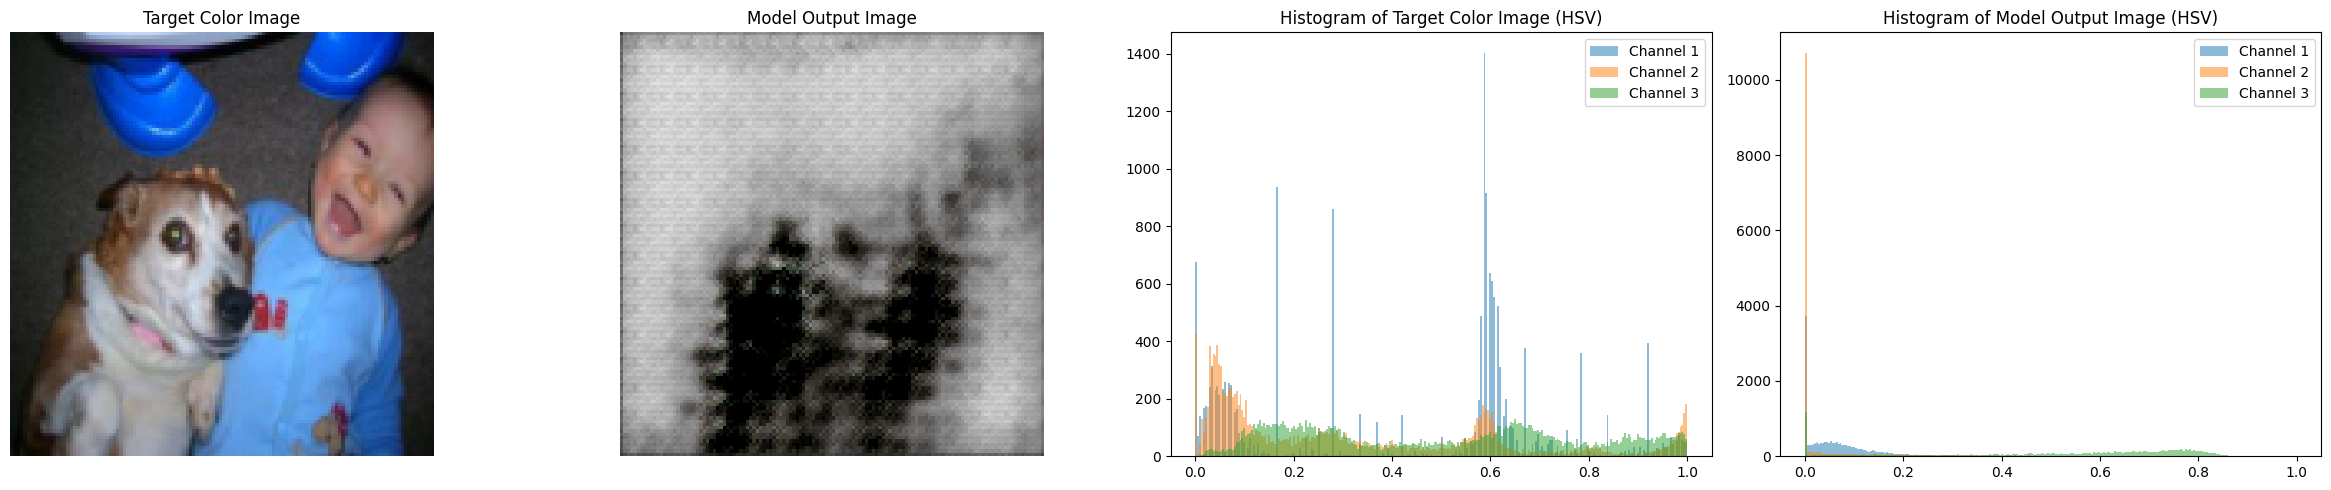

Epoch 67/90, Loss: PerceptualLoss, Optimizer: Adam, Train Loss: 104.7106, Val Loss: 110.2658


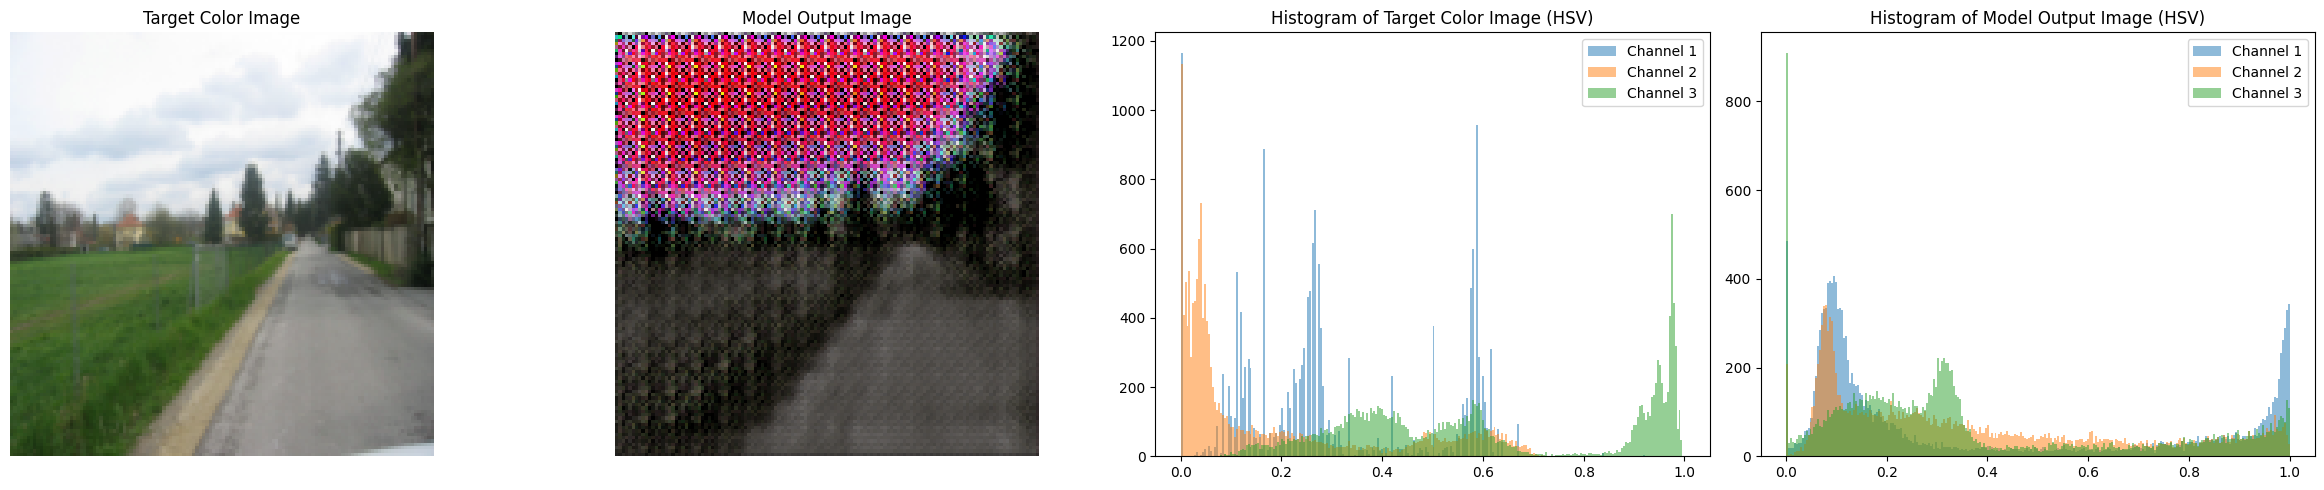

Epoch 73/90, Loss: PerceptualLoss, Optimizer: Adam, Train Loss: 92.4606, Val Loss: 99.3498


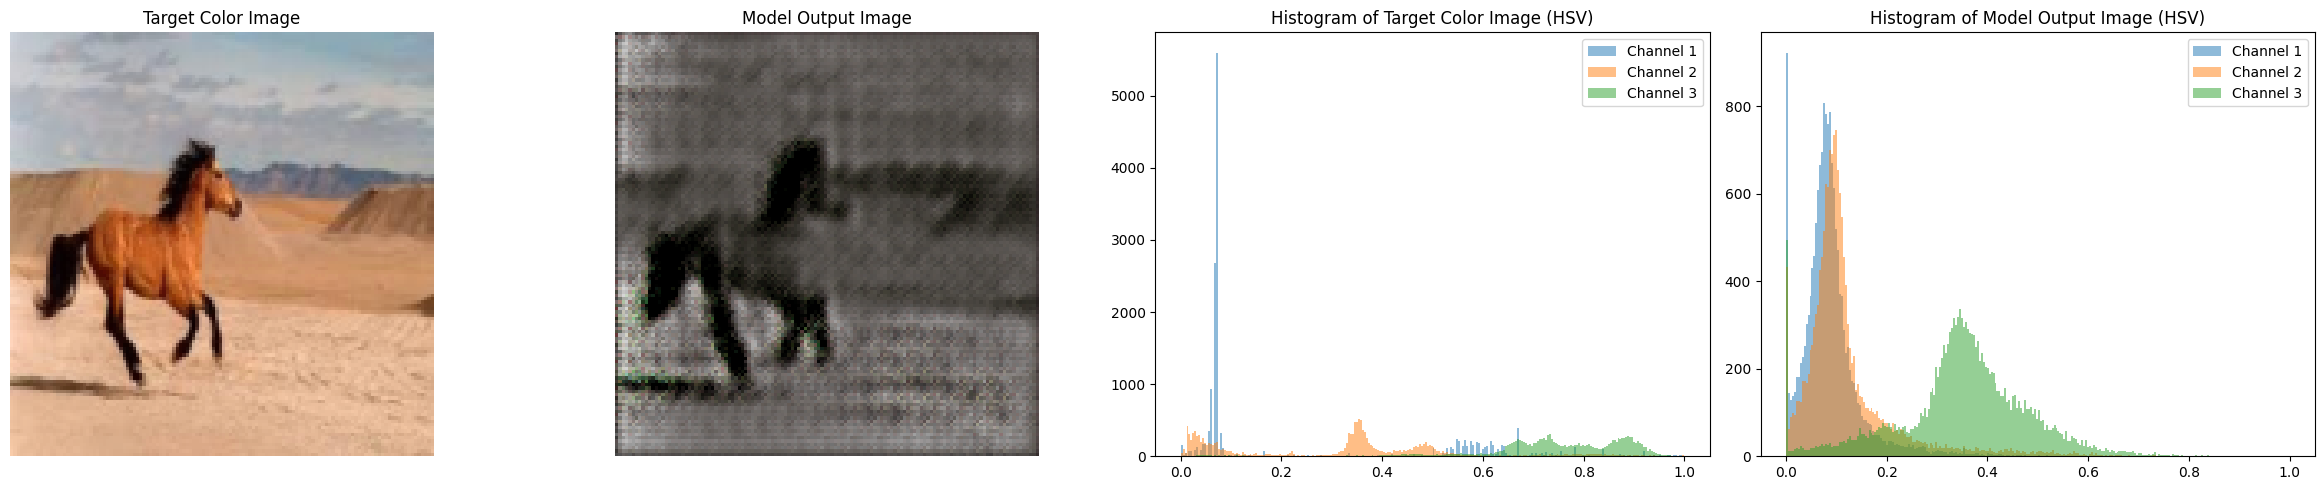

Epoch 76: Switching to MSELoss with optimizer RMSprop.
Epoch 79/90, Loss: MSELoss, Optimizer: RMSprop, Train Loss: 0.0632, Val Loss: 0.0571


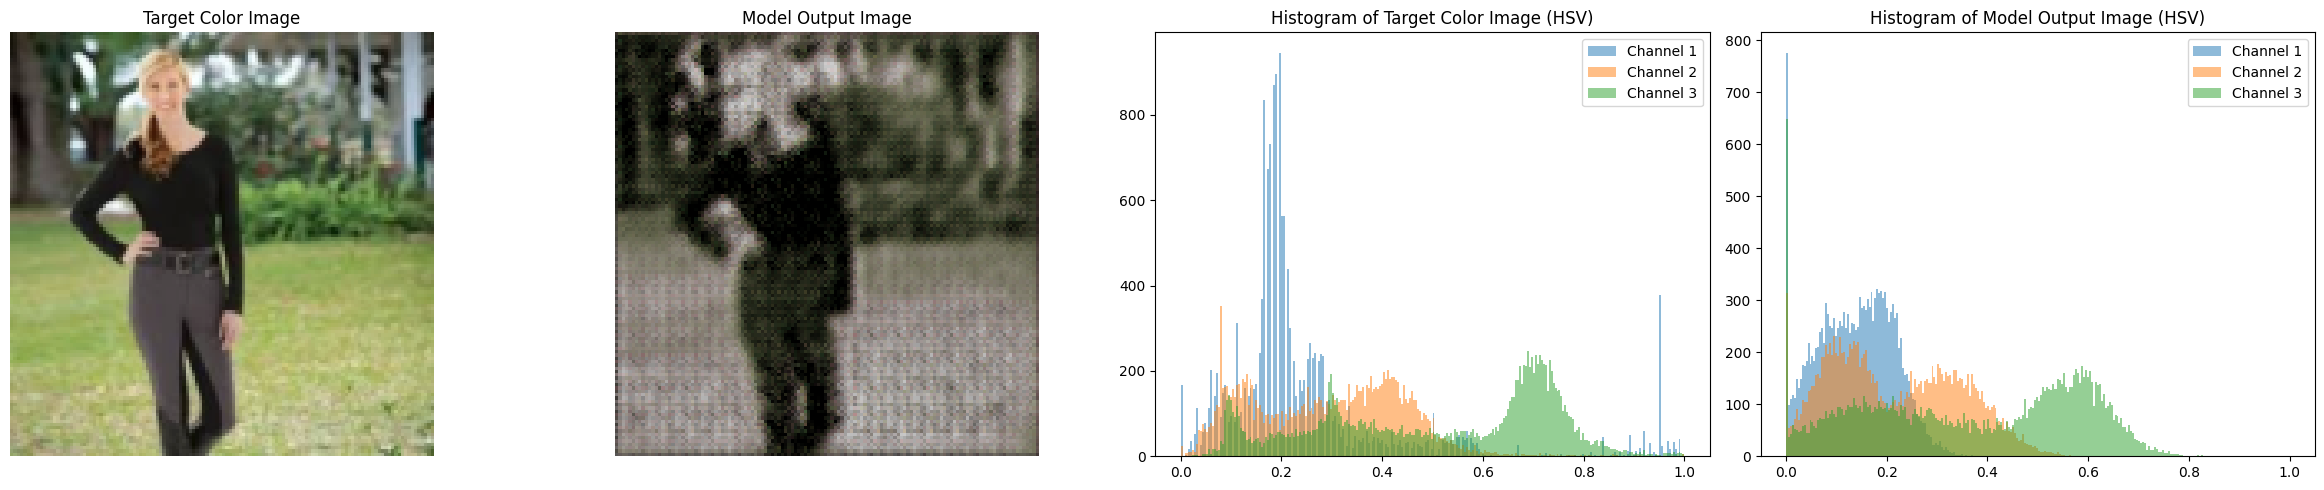

Epoch 85/90, Loss: MSELoss, Optimizer: RMSprop, Train Loss: 0.0541, Val Loss: 0.0474


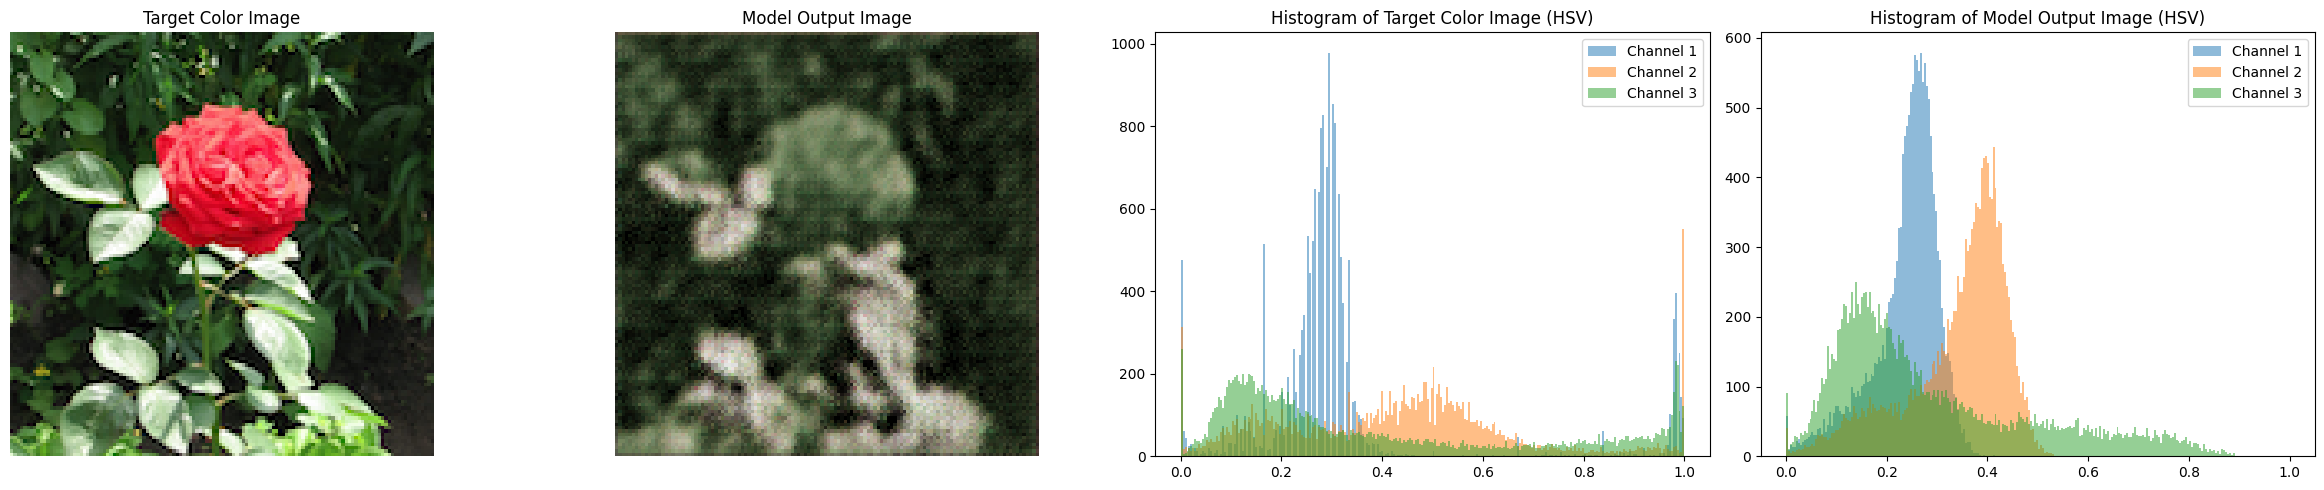

Training completed.


In [53]:
# Define your loss functions
mse_loss = nn.MSELoss().to(device)
mse_for_psnr = nn.MSELoss().to(device)
psnr_loss = lambda output, target: 20 * torch.log10(1.0 / torch.sqrt(mse_for_psnr(target.to(device), output)))
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
ssim_loss = lambda output, target: 1 - ssim_metric(output, target.to(device))
perceptual_loss = PerceptualLoss().to(device)

lr_divisor = 1

optimizer_configs = {
    mse_loss: [optim.Adam(Model_C.parameters(), lr=0.0005 / lr_divisor), optim.RMSprop(Model_C.parameters(), lr=0.0001 / lr_divisor)],
    psnr_loss: [optim.Adam(Model_C.parameters(), lr=0.00001 / lr_divisor), optim.RMSprop(Model_C.parameters(), lr=0.00005 / lr_divisor)],
    ssim_loss: [optim.Adam(Model_C.parameters(), lr=0.001 / lr_divisor),  optim.RMSprop(Model_C.parameters(), lr=0.0001 / lr_divisor)],
    perceptual_loss: [optim.Adam(Model_C.parameters(), lr=0.001 / lr_divisor), optim.RMSprop(Model_C.parameters(), lr=0.0005 / lr_divisor)]
}
# Loss functions list for cycling
criterion_list = [mse_loss, psnr_loss, ssim_loss, perceptual_loss]
# Train models and store results
epochs = 90

train_losses, val_losses, Model_C = train(Model_C, criterion_list, optimizer_configs, train_loader, val_loader_from_decoder, epochs)
print("Training completed.")

#criterions = [mse_loss] #lr=0.0005 Adam, lr=0.01 SGD, lr=0.0001 RMSprop
#criterions = [psnr_loss] # lr=0.0001 Adam, lr=0.0005 SGD, lr=0.00005 RMSprop
#criterions = [ssim_loss] # lr=0.01 Adam, lr=0.1 SGD, lr=0.0001 RMSprop
#criterions = [perceptual_loss] # lr=0.001 Adam lr=0.001 SGD, lr=0.0005 RMSprop


In [54]:
def plot_losses(train_losses_list, val_losses_list):
    plt.figure(figsize=(10, 6))

    # Plot training losses
    if isinstance(train_losses_list[0], list):
        for i, train_losses in enumerate(train_losses_list):
            plt.plot(range(1, len(train_losses) + 1), train_losses, label=f"Model {i+1} - Train Loss")
    else:
        plt.plot(range(1, len(train_losses_list) + 1), train_losses_list, label="Train Loss")

    # Plot validation losses
    if isinstance(val_losses_list[0], list):
        for i, val_losses in enumerate(val_losses_list):
            plt.plot(range(1, len(val_losses) + 1), val_losses, label=f"Model {i+1} - Validation Loss", linestyle='--')
    else:
        plt.plot(range(1, len(val_losses_list) + 1), val_losses_list, label="Validation Loss", linestyle='--')

    plt.title("Train and Validation Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

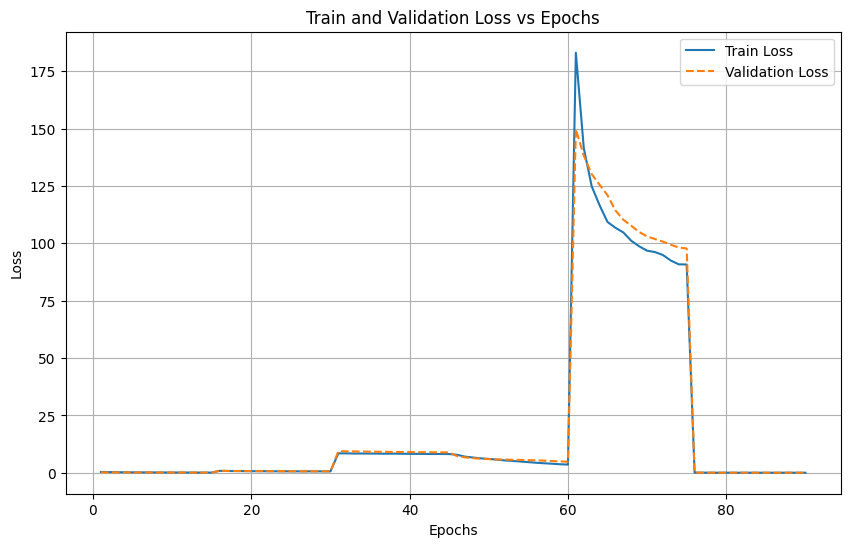

In [55]:
plot_losses(train_losses, val_losses)

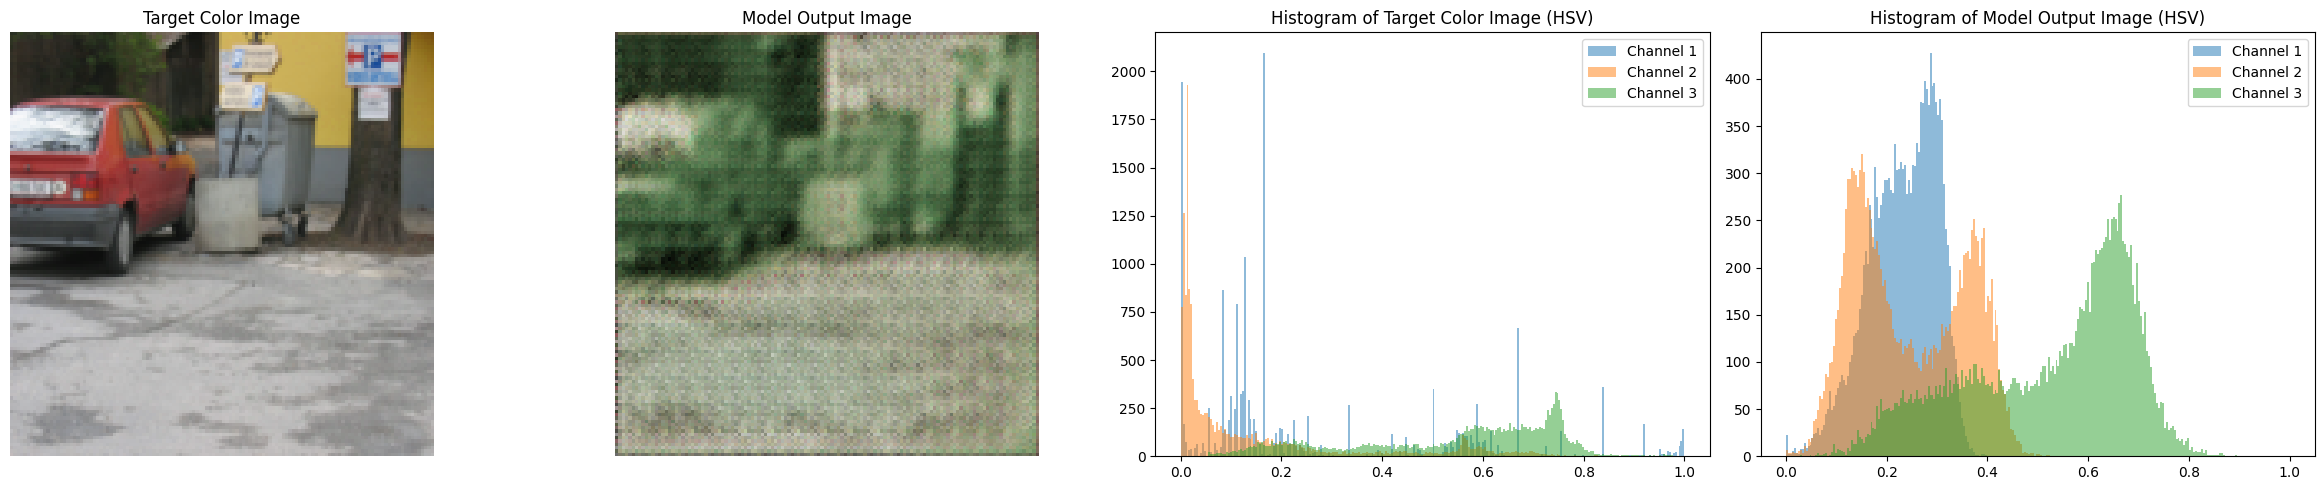

In [56]:
Model_C.to('cpu')  # Ensure the model is on the CPU if you're not using CUDA
visualize_model_output(Model_C, val_loader_from_decoder)

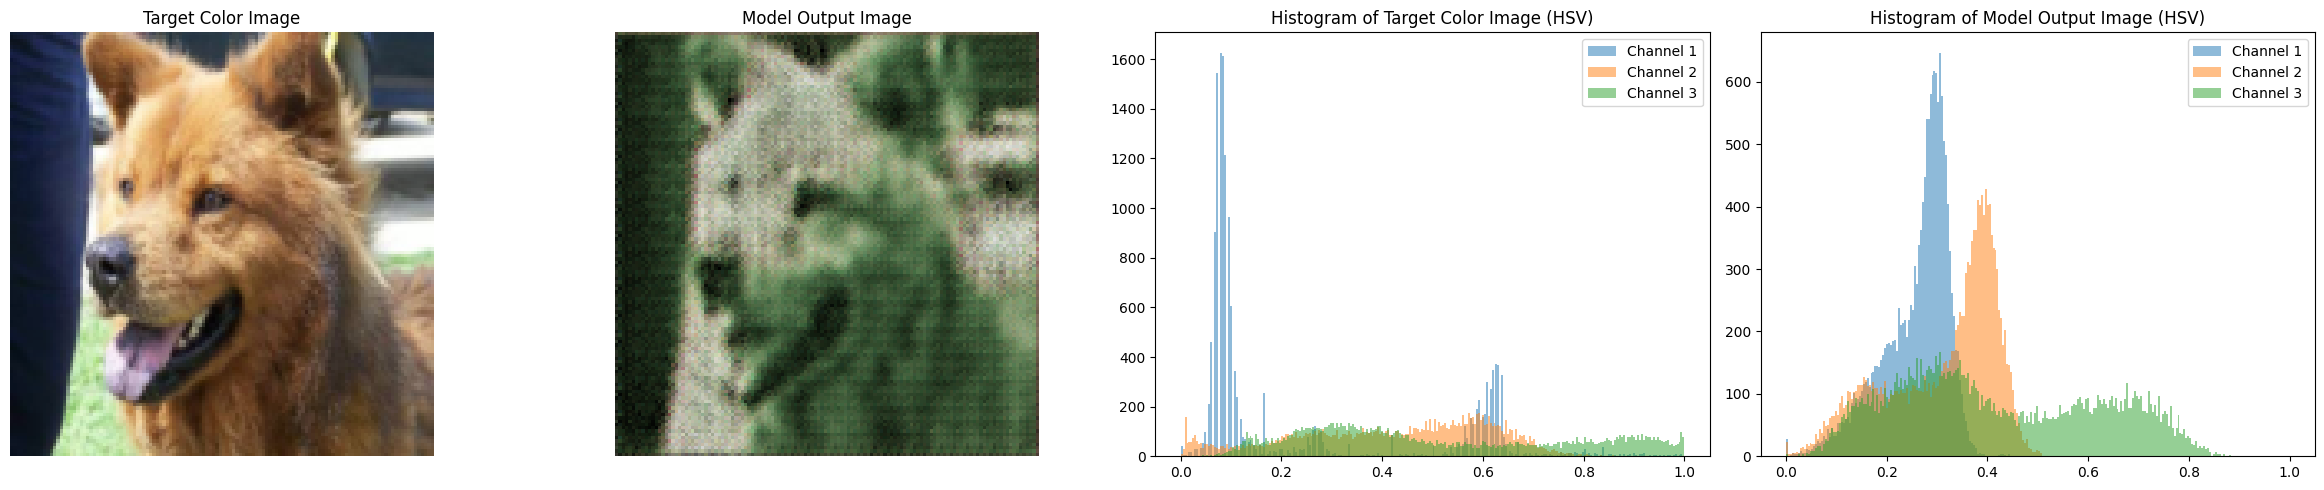

In [57]:
Model_C.to('cpu')  # Move the model to CPU if it's not already there
visualize_model_output(Model_C, train_loader) 

In [58]:
torch.save(Model_C.state_dict(), "Model_C.pth")